# Libraries and helper functions

In [1]:
import pandas as pd
import os
import numpy as np
pd.set_option('display.max_colwidth', None)
from collections import OrderedDict
from awswrangler import s3
from textblob import TextBlob
from scipy.spatial.distance import cdist
import boto3
import swifter
import langdetect
import seaborn as sns
import re
import pickle
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sentence_transformers import SentenceTransformer
from bertopic.representation import MaximalMarginalRelevance
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
#!python -m spacy download en_core_web_sm
from awswrangler import config
from collections import defaultdict



session = boto3.Session(profile_name="dbcordeiro_projects", region_name="us-east-1")
config.session = session

s3 = session.client("s3")

def data_description(df):
    print('Variables:\n\n{}'.format(df.dtypes), end='\n\n')
    print('Number of rows {}'.format(df.shape[0]), end='\n\n')
    print('Number of columns {}'.format(df.shape[1]), end='\n\n')
    print('NA analysis'.format(end='\n'))
    for i in df.columns:
        print('column {}: {} {}'.format(i,df[i].isna().any(), df[i].isna().sum()))

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def get_language(text):
    try:
        return langdetect.detect(text)
    except KeyboardInterrupt as e:
        raise e
    except:
        return 'ERROR'


# Reading Data

In [2]:
df = pd.read_parquet("s3://topic-modelling-reviews/filtered_reviews_dataset/train_reviews.parquet")

In [3]:
df = reduce_mem_usage(df)

Mem. usage decreased to 154.82 Mb (0.0% reduction)


# Data Description

In [4]:
data_description(df)

Variables:

title          string[python]
text           string[python]
parent_asin    string[python]
dtype: object

Number of rows 6764067

Number of columns 3

NA analysis
column title: False 0
column text: False 0
column parent_asin: False 0


It seems that there is no NAs, however one can check that some reviews and title reviews has NAs strings without any information like None, N/A, na, nah, etc. 

It could occurs in just the title, just in text or in both. Rows with NAs in both title and text will be removed. It is really small subset of data (< 1k)

In [4]:
df_nas = df[
    (df['title'].isin(['na', 'NA', 'nah', 'NAH', 'n/a', 'N/A', 'None', 'none', 'no', 'NONE', 'NO'])) 
    & (df['text'].isin(['na', 'NA', 'nah', 'NAH', 'n/a', 'N/A', 'None', 'none', 'no', 'NONE', 'NO']))
]

df = df.drop(df_nas.index)

Merge the title and text as one text as title could also provide information about review

In [ ]:
df['title_text_review'] = df[['title', 'text']].swifter.apply(
    lambda x: x['title'] +  '. ' + x['text'], axis=1
)
df = df.drop(['title', 'text'], axis=1)

Check language distribution and translate all of them to english. dataset after lang detect will be saved since it takes a few hours to process.

In [2]:
# df['language'] = df['title_text_review'].swifter.apply(get_language)
# df.to_parquet('../data/df_after_lang_detect.parquet')d
df = pd.read_parquet('../../data/interim/df_after_lang_detect.parquet')

Reviews and titles with emoji will be excluded since that is no possibility of translation. Also, reviews with less than 20 characters will be removed

In [7]:
df[df['language'] == 'ERROR']

,parent_asin,title_text_review,language
15226,B0935ZDCYD,🤔. 🤔,ERROR
17369,B00I3LHEGQ,----------------. -----------------------,ERROR
27618,B07PYFFWTS,☹️. ☹️,ERROR
35282,B076HRZJ66,1. 1,ERROR
43983,B08FHMR3MH,👎. 👎,ERROR
...,...,...,...
6726779,B07SPJ5SHK,👎. 👎,ERROR
6746492,B07CJV6PBJ,🤔. 🙄,ERROR
6754149,B097TBJYZR,👎🏽. 👎🏽,ERROR
6761902,B07QY4T41S,6/10. 6/10,ERROR


In [8]:
df_aux = df[['language', 'title_text_review']].groupby('language').count().reset_index().sort_values(by='title_text_review', ascending=False)
df_aux

,language,title_text_review
9,en,6564993
1,af,72227
10,es,60446
8,de,14882
7,da,7204
24,nl,6953
32,so,4450
25,no,4382
14,fr,3782
27,pt,3062


Pandas Apply: 100%|██████████| 40/40 [00:00<00:00, 69356.00it/s]


<Axes: xlabel='language', ylabel='title_text_review'>

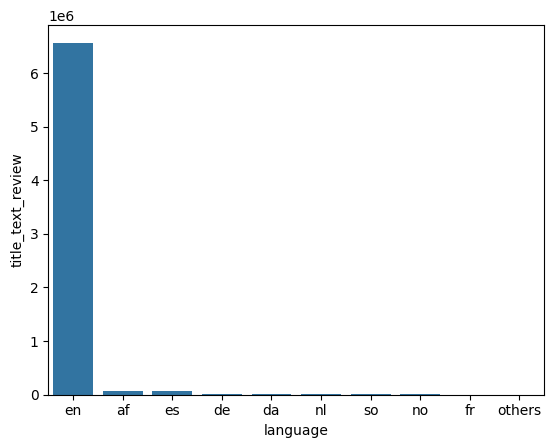

In [9]:
df_aux = df[['language', 'title_text_review']].groupby('language').count().reset_index().sort_values(by='title_text_review', ascending=False)
df_aux['language'] = df_aux.swifter.apply(lambda x: x['language'] if x['title_text_review'] > 3500 else 'others', axis=1)
sns.barplot(x='language', y='title_text_review', data=df_aux)

# Topic Modelling

Use sentiment polarity to retrieve only reviews with negative sentiment

In [70]:
df['text_length'] = df['title_text_review'].swifter.apply(lambda x: len(x))


Pandas Apply:   0%|          | 0/662318 [00:00<?, ?it/s]

In [3]:
df = df[df['language'] != 'ERROR']
df['title_text_review'] = df['title_text_review'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
df['text_length'] = df['title_text_review'].swifter.apply(lambda x: len(x))
df[(df['text_length'] < 1500) & (df['text_length'] > 60)]
df = df[df['language'] == 'en']
df = df.sample(4000000, random_state=42)
df['review_sentiment'] = df['title_text_review'].swifter.apply(lambda x: TextBlob(x).sentiment.polarity)
df = df[df['review_sentiment'] < -.2]
df.drop(columns=['text_length', 'language'], inplace=True)

Pandas Apply:   0%|          | 0/6763024 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4000000 [00:00<?, ?it/s]

Remove some words that appears a lot and do not bring much information about the product such as the word product, amazon or words that bring positive review (such as good, great,fine)

In [83]:
def spacy_tokenizer(doc):
    return [
        token.text
        for token in doc 
        if 
        token.is_alpha
        and not token.is_punct
        and not token.is_stop
        and not token.ent_type_ in {'ORG', 'PRODUCT', 'CARDINAL', 'DATE'}
        and token.dep_ in {'amod', 'advmod','neg','advcl', 'pobj', 'xcomp', 'dobj', 'ROOT'} 
        and token.head.pos_ in {'NOUN', 'ADJ', 'VERB'}
    ]

words_to_remove = [
    'star', 'stars','one', 'two', 'three', 'nt', 'n\'t', 'doesnt', 'dont', 'didnt', 'wasnt', 'werent', 'wouldnt', 
    'couldnt', 'shouldnt', 'havent', 'hasnt', 'hadnt', 'aint'
]

nlp = spacy.load("en_core_web_sm", disable=['lemmatizer'])

nlp.max_length = 4500000
for i in words_to_remove:
    nlp.Defaults.stop_words.add(i)

In [ ]:
# Embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
sentence_model.save("../model_deploy_test/all-MiniLM-L6-v2")
embeddings = sentence_model.encode(df['title_text_review'].tolist())

# Iniciate UMAP

umap_model = UMAP(
    n_neighbors=30,
    n_components=3,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

#HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size=70,
    gen_min_span_tree=True,
    prediction_data=True
)

In [6]:
vectorizer_model = CountVectorizer(
    tokenizer=lambda doc: spacy_tokenizer(nlp(doc)),
    ngram_range = (1, 3),
    lowercase=True
)

In [7]:
representation_model = MaximalMarginalRelevance(diversity=0.8)

batch_size = 12000
topic_models = []
for i in range(0, len(df), batch_size):
    df_batch = df.iloc[i:i+batch_size]

    topic_model_i = BERTopic(
        embedding_model=sentence_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        language='english',
        calculate_probabilities=True,
        representation_model=representation_model,
        top_n_words=10,
        nr_topics='auto'
    ).fit(df_batch['title_text_review'], embeddings=embeddings[i:i+batch_size])

    topic_models.append(topic_model_i)

merged_model = BERTopic.merge_models(topic_models, min_similarity=1)

In [87]:
merged_model = BERTopic.merge_models(topic_models, min_similarity=1)

In [162]:
distances = cdist(embeddings, merged_model.topic_embeddings_, 'cosine')
top_n = 5  # Number of representative documents you want
closest_docs = {}

for topic_idx, embeddings in enumerate(merged_model.topic_embeddings_):
    # Sorting indices by distance for each topic
    sorted_indices = np.argsort(distances[:, topic_idx])
    # Selecting the top N closest documents
    closest_docs[topic_idx] = df.iloc[sorted_indices[:top_n]]['title_text_review'].tolist()

93 topics were found

In [88]:
merged_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,611213,0_nt_working_waste_horrible,"[nt, working, waste, horrible, bought, quality, return, charge, recommend, tried]",NaN
1,1,51105,1_poor_good_broken_hard,"[poor, good, broken, hard, small, star work, return, buy, quality, disappointed]",NaN


# Topics description and visualization

In [89]:
merged_model.visualize_barchart(top_n_topics=8)

A lot of 'nt', probably because of words like doesnt, werent, didnt in which just the 'does', 'do', 'did' parts were removed. It is necessary to add these stop words completely on nlp tokenizer. 

In [90]:
merged_model.visualize_topics()

ValueError: zero-size array to reduction operation maximum which has no identity

Many topics are really close to each other so they probably are going to be merged so one can work with less but representative clusters. After merge near topics, one can obtain 16 well separated clusters.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
distance_matrix = cosine_similarity(np.array(merged_model.topic_embeddings_))
dist_df = pd.DataFrame(distance_matrix, columns=merged_model.topic_labels_.values(), 
                       index=merged_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index': 
            continue
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]
pair_dist_df.sort_values('distance', ascending = False).head(60)

Lots of topics could be merged

In [66]:
merged_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,611213,0_the_it_to_and,"[the, it, to, and, not, this, is, of, for, my]","[All broken after a month of use. So disappointed, out of the 6 pack we have only 1 left in less than 60 days. The charging port snapped off on all of them. The one I pictured was after 1 week use. I unplugged my iPhone and it just fell off. No way to contact seller, so its a big waste of money., Useless. You can do the same things without the firestick you can with it. Literally a useless product. Bought it thinking it an alternative to cable and satellite. Turns out you still have to pay for cable. It does nothing for me and I regret purchasing it. A waste of money and time. They advertise something that does nothing your smart tv can't do without it. Save yourself the money. Amazon sucks. I'm discontinuing my prime account as well. Second time I've been disappointed by Amazon this month. They don't give you refunds but after 1-2 weeks. Well Amazon you can't have anymore of my Money, Absolutely awful look at pics and read review. First off they sent me instructions for installing a screen on a cell phone (shown in picture) and I dont think that was a mistake that is just all they send. There are no sticker pull tabs to help with installation. It says just drop it on. Once dropped on bubbles everywhere and as you can see in the picture impossible to get them all the way out. They dont even send a squeegee you have to hack up the box with a knife and use that. Its not even close to being tempered glass as advertised. 1,000% plastic. And the touchscreen feature barely works with it on also opposite of whats advertised. Do yourself a favor and do not buy this!]"
1,1,1013,1_star_one_stars_two,"[star, one, stars, two, very, wrong, poor, quality, to, bad]","[One Star. Terrible, One Star. bad, One Star. Terrible]"
2,2,985,2_star_one_stars_two,"[star, one, stars, two, too, wrong, not, very, to, it]","[One Star. Terrible, One Star. bad, One Star. T.T bad]"
3,3,981,3_star_one_stars_two,"[star, one, stars, two, wrong, not, very, poor, quality, to]","[One Star. Very disappointed, One Star. bad!!!!, One Star. bad]"
4,4,981,4_star_one_stars_two,"[star, one, stars, two, not, it, very, good, to, wrong]","[One Star. Terrible!, One Star. bad, One Star. very bad]"
5,5,974,5_star_one_stars_two,"[star, one, stars, two, quality, poor, not, broken, good, wrong]","[One Star. poor, One Star. Poor!, One Star. Very bad]"
6,6,970,6_star_one_stars_two,"[star, one, stars, two, not, quality, very, it, poor, was]","[One Star. bad quality., One Star. Terrible, One Star. bad]"
7,7,969,7_star_one_stars_two,"[star, one, stars, two, bad, it, not, very, too, was]","[One Star. bad product!!!!!!!, One Star. Disappointed, One Star. bad]"
8,8,963,8_star_one_stars_two,"[star, one, stars, two, wrong, not, small, very, it, to]","[One Star. Very bad, One Star. Terrible, One Star. It's bad]"
9,9,962,9_star_one_stars_two,"[star, one, stars, two, not, too, it, wrong, very, to]","[One Star. Bad product., One Star. bad one, One Star. bad]"


In [65]:
merged_model.merge_topics(df['title_text_review'].tolist(), merge_0)

In [50]:
connections = defaultdict(set)

for a, b, sim in similar_topic_pairs:
    if sim > threshold:
        connections[a].add(b)
        connections[b].add(a)

In [55]:
def find_group(topic, group_map):
    # find root
    root = topic
    while group_map[root] != root:
        root = group_map[root]
    # path compression
    while topic != root:
        next = group_map[topic]
        group_map[topic] = root
        topic = next
    return root

group_map = {i: i for i in connections}  # initialize each topic as its own group

for topic in connections:
    for connected_topic in connections[topic]:
        root1 = find_group(topic, group_map)
        root2 = find_group(connected_topic, group_map)
        if root1 != root2:
            group_map[root2] = root1  # union

merged_groups = defaultdict(set)
for topic, root in group_map.items():
    merged_groups[find_group(root, group_map)].add(topic)


In [ ]:
for group in merged_groups.values():
    if len(group) > 1:  # We only need to merge if there are at least two topics in the group
        # Ensure documents are correctly defined
        docs = df['title_text_review'].tolist()  # Ensure this pulls the documents correctly
        merged_model.merge_topics(docs, list(group))

In [58]:
merged_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,611213,0_the_it_to_and,"[the, it, to, and, not, this, is, of, for, my]","[All broken after a month of use. So disappointed, out of the 6 pack we have only 1 left in less than 60 days. The charging port snapped off on all of them. The one I pictured was after 1 week use. I unplugged my iPhone and it just fell off. No way to contact seller, so its a big waste of money., Useless. You can do the same things without the firestick you can with it. Literally a useless product. Bought it thinking it an alternative to cable and satellite. Turns out you still have to pay for cable. It does nothing for me and I regret purchasing it. A waste of money and time. They advertise something that does nothing your smart tv can't do without it. Save yourself the money. Amazon sucks. I'm discontinuing my prime account as well. Second time I've been disappointed by Amazon this month. They don't give you refunds but after 1-2 weeks. Well Amazon you can't have anymore of my Money, Absolutely awful look at pics and read review. First off they sent me instructions for installing a screen on a cell phone (shown in picture) and I dont think that was a mistake that is just all they send. There are no sticker pull tabs to help with installation. It says just drop it on. Once dropped on bubbles everywhere and as you can see in the picture impossible to get them all the way out. They dont even send a squeegee you have to hack up the box with a knife and use that. Its not even close to being tempered glass as advertised. 1,000% plastic. And the touchscreen feature barely works with it on also opposite of whats advertised. Do yourself a favor and do not buy this!]"
1,1,25928,1_star_one_stars_two,"[star, one, stars, two, not, it, very, to, the, wrong]","[One Star. Terrible, One Star. bad, One Star. Terrible]"
2,2,985,2_star_one_stars_two,"[star, one, stars, two, not, to, it, very, too, wrong]","[One Star. Terrible, One Star. bad, One Star. T.T bad]"
3,3,981,3_star_one_stars_two,"[star, one, stars, two, it, not, very, to, bad, good]","[One Star. Very disappointed, One Star. bad!!!!, One Star. bad]"
4,4,970,4_star_one_stars_two,"[star, one, stars, two, not, it, quality, very, to, poor]","[One Star. Terrible!, One Star. bad, One Star. very bad]"
5,5,963,5_star_one_stars_two,"[star, one, stars, two, not, wrong, very, it, to, the]","[One Star. poor, One Star. Poor!, One Star. Very bad]"
6,6,961,6_star_one_stars_two,"[star, one, stars, two, very, not, it, wrong, too, to]","[One Star. bad quality., One Star. Terrible, One Star. bad]"
7,7,959,7_star_one_stars_two,"[star, one, stars, two, not, it, very, to, wrong, small]","[One Star. bad product!!!!!!!, One Star. Disappointed, One Star. bad]"
8,8,955,8_star_one_stars_two,"[star, one, stars, two, not, very, it, bad, to, the]","[One Star. Very bad, One Star. Terrible, One Star. It's bad]"
9,9,953,9_star_one_stars_two,"[star, one, stars, two, not, it, very, good, bad, to]","[One Star. Bad product., One Star. bad one, One Star. bad]"


# Predictions

Prediction will be made using the average embedding of product reviews since it is desired to find the characteristics of a product and not just a single review.

Embedding will be normalized so each review will contribute equally to the average. Without normalization reviews with higher length will contribute more.

In [ ]:
def calc_mean_embedding(embedding_list):
    return np.mean(embedding_list, axis=0)

def find_closest_embedding(first_embeddings, topic_embeddings):
    similarities = cosine_similarity([first_embeddings], topic_embeddings)
    closest_topic = np.argmax(similarities)
    return closest_topic


def find_top_topics(first_embeddings, topic_embeddings, n=3):
    similarities = cosine_similarity([first_embeddings], topic_embeddings)
    top_topics = np.argpartition(similarities[0], -n)[-n:]
    return top_topics.tolist()

topic_embeddings = merged_model.topic_embeddings_

df['embeddings'] = list(embeddings)
df_grouped = df[['parent_asin', 'embeddings']].groupby('parent_asin').agg(calc_mean_embedding).reset_index()

df_grouped['product_topics'] = df_grouped['embeddings'].swifter.apply(lambda emb: find_closest_embedding(emb, topic_embeddings))

In [ ]:
top_words = []
for i in topic_model.topic_representations_[0]:
    top_words.append(i[0])

print("The top words that describes the negatives reviews are:")
for i in range(0,len(top_words)):
    print(top_words[i])